### Import Libraries
We import all required libraries including tools for data manipulation, preprocessing, machine learning models, and visualization.

In [1]:
# 0. Imports and Setup

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.sparse import hstack
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zahinos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zahinos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zahinos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zahinos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Remove Duplicates and Empty Records
This function drops any reviews that are duplicates or contain empty or non-informative text.

In [2]:
# 1. Data Preprocessing Functions

def drop_duplicates_empty(df):
    # Remove 'Includes Special Offers' from the 'name' column, but do not drop the row
    df['name'] = df['name'].str.replace('Includes Special Offers', '', regex=False).str.strip()
    df = df.dropna(subset=['reviews.text', 'reviews.rating'])
    df = df.drop_duplicates(subset=['asins', 'reviews.text'])
    return df

def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", '', str(text))
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

def preprocess_reviews(df):
    df['combined_reviews'] = df['reviews.title'].fillna('').str.lower() + ' ' + df['reviews.text'].fillna('').str.lower()
    df['combined_reviews'] = df['combined_reviews'].apply(clean_text)
    df = df.drop(['reviews.title', 'reviews.text'], axis=1)
    return df

def add_sentiment_column(df):
    def categorize_rating(rating):
        if rating >= 4:
            return 'positive'
        elif rating == 3:
            return 'neutral'
        else:
            return 'negative'
    df['sentiment'] = df['reviews.rating'].apply(categorize_rating)
    return df

def tokenize_reviews(df, col='combined_reviews', new_col='tokens'):
    df[new_col] = df[col].apply(word_tokenize)
    return df

def remove_stopwords(df, tokens_col='tokens', new_col='tokens_nostop', language='english'):
    stop_words = set(stopwords.words(language))
    df[new_col] = df[tokens_col].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
    return df

def lemmatize_tokens(df, tokens_col='tokens_nostop', new_col='tokens_lemmatized'):
    lemmatizer = WordNetLemmatizer()
    df[new_col] = df[tokens_col].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
    return df

def preprocess_pipeline(df):
    df = drop_duplicates_empty(df)
    df = preprocess_reviews(df)
    df = add_sentiment_column(df)
    df = tokenize_reviews(df)
    df = remove_stopwords(df)
    df = lemmatize_tokens(df)
    df['lemmatized_str'] = df['tokens_lemmatized'].apply(lambda tokens: ' '.join(tokens))
    return df

def preprocess_and_lemmatize_names_categories(df):
    df['name'] = df['name'].fillna('')
    df['categories'] = df['categories'].fillna('')
    df['name'] = df['name'].str.replace('Includes Special Offers', '', regex=False).str.strip()
    df['name_category'] = df['name'] + ' ' + df['categories']
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    df['name_category_clean'] = df['name_category'].apply(clean_text)
    df['name_category_tokens'] = df['name_category_clean'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    df['name_category_nostop'] = df['name_category_tokens'].apply(
        lambda tokens: [word for word in tokens if word not in stop_words]
    )
    lemmatizer = WordNetLemmatizer()
    df['name_category_lemmatized'] = df['name_category_nostop'].apply(
        lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
    )
    df['name_category_lemmatized'] = df['name_category_lemmatized'].apply(lambda tokens: ' '.join(tokens))
    return df

### Load the Dataset
The dataset is loaded from a CSV file which contains customer reviews of various Amazon products.

In [3]:
csv_path = '../data/Processed/combined_reviews.csv'
df = pd.read_csv(csv_path)

df = preprocess_pipeline(df)

### Sentiment Model Training and Evaluation
This code trains and compares four models (Logistic Regression, SVM, Random Forest, Naive Bayes) to classify review sentiment using TF-IDF text features and review length. It uses GridSearchCV to find the best parameters, selects the top model based on F1-macro score, evaluates it on a test set, and displays misclassified examples for analysis.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np


# Prepare features and labels
X_text = df['lemmatized_str']
y = df['sentiment']

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize text
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Add review length as a feature
train_length = np.array([len(x.split()) for x in X_train_text]).reshape(-1, 1)
test_length = np.array([len(x.split()) for x in X_test_text]).reshape(-1, 1)

X_train_features = hstack([X_train_tfidf, train_length])
X_test_features = hstack([X_test_tfidf, test_length])

# Define models and grids
models_and_grids = [
    (
        "Logistic Regression",
        LogisticRegression(max_iter=2000, random_state=42),
        {'C': [0.01, 0.1, 1, 10]}
    ),
    (
        "Linear SVC",
        LinearSVC(max_iter=1000, random_state=42),
        {'C': [0.01, 0.1, 1, 10]}
    ),
    (
        "Random Forest",
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
    ),
    (
        "Multinomial NB",
        MultinomialNB(),
        {'alpha': [0.5, 1.0, 2.0]}
    )
]

results = []

for name, model, param_grid in models_and_grids:
    print(f"\n{name} - GridSearchCV")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
    try:
        grid.fit(X_train_features, y_train)
        print("Best params:", grid.best_params_)
        print("Best CV F1-macro:", grid.best_score_)
        results.append((name, grid.best_score_, grid.best_estimator_))
    except Exception as e:
        print(f"Error with {name}: {e}")

# Find and display the best model
if results:
    best_name, best_score, best_sentiment_model = max(results, key=lambda x: x[1])
    print(f"\nBest sentiment model: {best_name} with F1-macro = {best_score:.4f}")
    # Evaluate on test set
    y_pred = best_sentiment_model.predict(X_test_features)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("No model was successfully trained.")


# Find indices of misclassified samples
import numpy as np
mis_idx = np.where(y_pred != y_test)[0]
y_test_reset = y_test.reset_index(drop=True)

pd.set_option('display.max_colwidth', None)

misclassified_df = pd.DataFrame({
    'actual_sentiment': y_test_reset.iloc[mis_idx].values,
    'predicted_sentiment': y_pred[mis_idx],
    'combined_reviews': X_test_text.iloc[mis_idx].values
})

pd.set_option('display.max_colwidth', None)

print(misclassified_df.head())


Logistic Regression - GridSearchCV
Best params: {'C': 10}
Best CV F1-macro: 0.7445951780211998

Linear SVC - GridSearchCV


c:\Users\Zahinos\Desktop\AI\Week5\Day5(4)\lab-qlora-tuning-peft\.conda\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 1}
Best CV F1-macro: 0.7344040786029454

Random Forest - GridSearchCV
Best params: {'max_depth': None, 'n_estimators': 100}
Best CV F1-macro: 0.6754670895220221

Multinomial NB - GridSearchCV
Best params: {'alpha': 0.5}
Best CV F1-macro: 0.34770862693541504

Best sentiment model: Logistic Regression with F1-macro = 0.7446
              precision    recall  f1-score   support

    negative       0.89      0.74      0.81       463
     neutral       0.78      0.48      0.59       516
    positive       0.97      0.99      0.98     10981

    accuracy                           0.96     11960
   macro avg       0.88      0.74      0.79     11960
weighted avg       0.96      0.96      0.96     11960

Confusion Matrix:
 [[  342    23    98]
 [   19   247   250]
 [   24    47 10910]]
  actual_sentiment predicted_sentiment  \
0          neutral            positive   
1         positive            negative   
2         positive             neutral   
3          neutral       

### Save Model and Vectorizer
We persist the trained sentiment classifier and TF-IDF vectorizer using `joblib` so they can be reused later.

In [5]:
# Save the best model and vectorizer
joblib.dump(best_sentiment_model, 'best_sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_sentiment.pkl')

['tfidf_vectorizer_sentiment.pkl']

### Predict Sentiment Labels
This function uses the trained model to predict sentiment for each review and append it to the dataset.

In [6]:
# 2. Sentiment Classification Function

def predict_sentiment(df, tfidf_vectorizer, best_sentiment_model):
    X_tfidf = tfidf_vectorizer.transform(df['lemmatized_str'])
    review_length = np.array([len(x.split()) for x in df['lemmatized_str']]).reshape(-1, 1)
    X_vec = hstack([X_tfidf, review_length])
    df['sentiment'] = best_sentiment_model.predict(X_vec)
    sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    df['sentiment_points'] = df['sentiment'].map(sentiment_map)
    return df

### Predict Sentiment Labels
This function uses the trained model to predict sentiment for each review and append it to the dataset.

In [7]:
df = predict_sentiment(df, tfidf_vectorizer, best_sentiment_model)

### Preprocess Product Names and Categories
We normalize the text in product names and categories for consistency before clustering.

In [8]:
df = preprocess_and_lemmatize_names_categories(df)

### Product Clustering with TF-IDF and KMeans
This function groups products based on text features (name + category) using KMeans clustering. It includes:

TF-IDF vectorization of product text

Elbow method + KneeLocator to automatically select the optimal number of clusters

Final KMeans clustering using the optimal k

PCA visualization to show cluster separation in 2D

Sample output of products per cluster

In [9]:
from kneed import KneeLocator
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 3. Clustering Function

def cluster_and_visualize_products(
    df,
    text_col='name_category_lemmatized',
    k_range=range(2, 11),
    n_components=50,
    random_state=42,
    show_samples=True,
    show_plot=True
):
    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df[text_col])

    # Elbow method
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(list(k_range), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

   # AUTOMATIC knee detection
    kneedle = KneeLocator(list(k_range), inertias, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow - 1
    if optimal_k is None:
        optimal_k = k_range[0]  # fallback if knee not found
    print(f"Optimal number of clusters (automatic): {optimal_k}")

    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=20)
    df['cluster'] = kmeans.fit_predict(X)

    # 2D visualization
    if show_plot:
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(X)
        plt.figure(figsize=(10, 6))
        for cluster_id in range(optimal_k):
            plt.scatter(
                X_pca[df['cluster'] == cluster_id, 0],
                X_pca[df['cluster'] == cluster_id, 1],
                label=f'Cluster {cluster_id}', alpha=0.5
            )
        plt.title('K-Means Clusters Visualization (PCA)')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()

    if show_samples:
        for cluster_id in range(optimal_k):
            print(f"\nCluster {cluster_id} sample products:")
            display(df[df['cluster'] == cluster_id][['name', 'categories']].head(10))

    return df, kmeans, vectorizer, X

### Cluster Reviews
We use KMeans to group products based on textual similarity using vectorized representations.

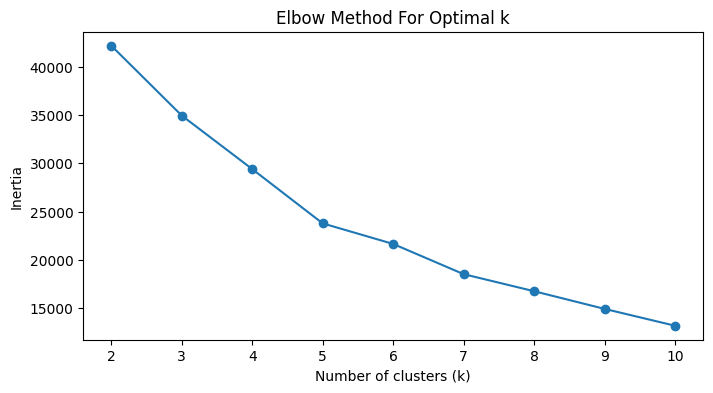

Optimal number of clusters (automatic): 4


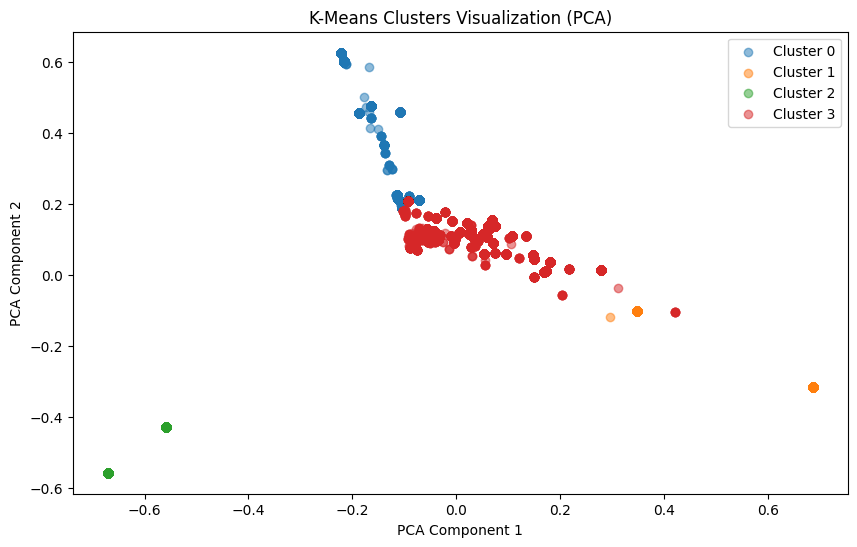

In [10]:
df, kmeans, cluster_vectorizer, X = cluster_and_visualize_products(df, show_samples=False, show_plot=True)

### Generate Unique Cluster Names with GPT-3.5 Turbo
This code uses OpenAI's GPT-3.5 Turbo to generate concise, non-generic names for each product cluster.

It takes the list of product names from each cluster.

Sends them to the GPT model via a custom prompt.

Ensures that each generated category name is unique (not reused).

Maps the final names back to the DataFrame under clustered_category.

This replaces manually defined cluster labels with human-like, interpretable category names.

In [ ]:
#!pip install dotenv
import openai
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

def get_category_name_openai(product_names, openai_api_key, model="gpt-3.5-turbo"):
    """
    Given a list of product names, use OpenAI to suggest a concise, precise unique category name.
    Returns only the category name as a string.
    """
    prompt = (
        "Given the following list of product names, suggest a concise, precise category name that best describes the majority of products and it is not generic. "
        f"Do NOT use any of these words: {', '.join(used_names)}\n"
        "Only return the category name, nothing else.\n\n"
        "Product names:\n" +
        "\n".join(product_names)
    )
    client = openai.OpenAI(api_key=openai_api_key)
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5,
        max_tokens=15,
    )
    return response.choices[0].message.content.strip()

# After clustering, replace your static cluster_name_map with OpenAI-generated names:

cluster_name_map = {}
used_names = set()
# Generate unique category names for each cluster using OpenAI
for cluster_id in sorted(df['cluster'].unique()):
    product_names = df[df['cluster'] == cluster_id]['name'].dropna().unique().tolist()
    if product_names:
        category_name = get_category_name_openai(product_names, openai_api_key)
        while category_name in used_names:
            category_name = get_category_name_openai(product_names, openai_api_key, prompt=prompt)
        used_names.add(category_name)
        cluster_name_map[cluster_id] = category_name
print(cluster_name_map)

df['clustered_category'] = df['cluster'].map(cluster_name_map)

{np.int32(0): 'Amazon Devices', np.int32(1): 'Tablet Devices', np.int32(2): 'Battery Packs', np.int32(3): 'E-Readers'}


### Load Quantized Language Model from Hugging Face (Mistral-7B Instruct)
This code loads a large language model (Mistral-7B) from Hugging Face using efficient 8-bit quantization via BitsAndBytes, which helps reduce memory usage without significant loss in precision.

Steps included:

Authenticate with Hugging Face Hub to access gated models using an API key from environment variables.

Use BitsAndBytesConfig to set 8-bit loading for the model.

Load the pre-trained model and tokenizer from the Hugging Face Hub with memory-efficient configuration.

This setup allows you to generate high-quality text using a powerful instruction-tuned model on standard hardware.

In [ ]:
from huggingface_hub import login
login(new_session=False)


#!pip install git+https://github.com/huggingface/accelerate.git
#!pip install git+https://github.com/huggingface/transformers.git
#!pip install BitsAndBytes
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from dotenv import load_dotenv
import os



load_dotenv()
hf_key = os.getenv("HF_KEY") # We need our Hugging Face API key to access gated models


# Load your saved model and tokenizer (update the path or model name as needed)
model_path = "mistralai/Mistral-7B-Instruct-v0.2"

# To minimize memory usage, without giving up precision, we will use 8-bit quantization instead of 32 with BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_quant_type="nf8",
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=False,
)

# Load the quantized model and tokenizer
blog_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    device_map="auto",
    use_auth_token=hf_key
)
blog_tokenizer = AutoTokenizer.from_pretrained(model_path, use_auth_token=hf_key)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Zahinos\Desktop\AI\Week5\Day5(4)\lab-qlora-tuning-peft\.conda\Lib\site-packages\transformers\models\auto\tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [ ]:
# Save the blog generator model and tokenizer locally
blog_model.save_pretrained('blog_generator')
blog_tokenizer.save_pretrained('blog_generator')

### Generate Blog-style Product Reviews per Category
This function creates realistic, helpful blog posts for each product category using a text generation model (like Mistral or GPT).

Key Features:
Sentiment Mapping: Converts labeled sentiment (positive, neutral, negative) into numeric scores to rank products.

Top Products and Complaints: For each category, it selects the top-rated products and extracts the most common complaints from negative reviews.

Few-shot Prompting: Uses a detailed prompt with multiple category examples to guide the model on how to write structured, helpful content.

Dynamic Prompt Creation: The function builds a unique prompt per category with actual product names, ratings, review counts, and complaint keywords.

Worst Product Highlight: Optionally includes a warning about the worst-rated product in the category.

Friendly and Informative Output: Uses a generation pipeline to produce human-like text tailored to help consumers make purchase decisions.

This is useful for turning structured review data into narrative content ready for blogs, newsletters, or product pages.

In [14]:
def generate_blogposts_for_all_categories(
    df,
    generator,
    n_shot_prompt=None,
    n_top_products=3,
    n_complaints=2,
    max_new_tokens=800,
    temperature=0.4,
    top_p=0.9,
    repetition_penalty=1.1
):
    from nltk.corpus import stopwords
    from collections import Counter

    # Set up text generation pipeline
    #generator = pipeline("text-generation", model=model, tokenizer=blog_tokenizer)  # Use device=0 for GPU, -1 for CPU

    # Map sentiment labels to numeric scores
    sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    df['sentiment_points'] = df['sentiment'].map(sentiment_map)
    blogposts = []
    def get_top_complaints(df, product_name, n=n_complaints):
        neg_reviews = df[(df['name'] == product_name) & (df['sentiment'] == 'negative')]['combined_reviews']
        words = ' '.join(neg_reviews).split()
        stop_words = set(stopwords.words('english'))
        filtered_words = [w.lower() for w in words if w.lower() not in stop_words and len(w) > 2]
        most_common = Counter(filtered_words).most_common(n)
        return [word for word, _ in most_common]

    n_shot_prompt = """
--- Blogpost for E-readers ---
Looking for the perfect e-reader? Here are our top picks!
1. Kindle Paperwhite (Avg. Rating: 4.8, 1200 reviews)
   Top complaints: screen glare, slow refresh
2. Kobo Clara HD (Avg. Rating: 4.7, 950 reviews)
   Top complaints: limited store, battery life
3. Kindle Oasis (Avg. Rating: 4.6, 800 reviews)
   Top complaints: price, weight

The Kindle Paperwhite stands out for its crisp display and waterproof design, making it ideal for reading anywhere. Kobo Clara HD is a great alternative with support for multiple formats, though some users wish for a larger store. The Kindle Oasis offers premium features, but its higher price and weight are noted by some reviewers.

The worst product is the Nook GlowLight 3 (Avg. Rating: 3.2).
Many customers report slow performance and frequent software glitches. Unless you’re a die-hard Nook fan, we recommend considering other options for a smoother reading experience.
---
--- Blogpost for Smart Tablets ---
Shopping for a smart tablet? Here are the top choices this year:
1. Apple iPad Air (Avg. Rating: 4.9, 2100 reviews)
   Top complaints: price, limited ports
2. Samsung Galaxy Tab S7 (Avg. Rating: 4.8, 1800 reviews)
   Top complaints: bloatware, charger speed
3. Amazon Fire HD 10 (Avg. Rating: 4.5, 1600 reviews)
   Top complaints: app selection, ads

The iPad Air is praised for its speed and display quality, though it comes at a premium. The Galaxy Tab S7 offers excellent multitasking, but some users dislike the pre-installed apps. The Fire HD 10 is a budget-friendly option, but its app ecosystem is more limited.

The worst product is the Lenovo Tab M8 (Avg. Rating: 3.4).
Users mention sluggish performance and a lackluster screen. For a better experience, consider one of the top-rated tablets above.
---
--- Blogpost for Smart Home Essentials ---
Upgrade your home with these smart essentials:
1. Amazon Echo Dot (Avg. Rating: 4.8, 3000 reviews)
   Top complaints: privacy, sound quality
2. Google Nest Hub (Avg. Rating: 4.7, 2500 reviews)
   Top complaints: screen size, setup
3. Philips Hue Bulb (Avg. Rating: 4.6, 2200 reviews)
   Top complaints: app issues, price

The Echo Dot is a favorite for its versatility and Alexa integration. Google Nest Hub excels at smart home control, though some wish for a larger display. Philips Hue bulbs offer vibrant lighting, but the app can be finicky.

The worst product is the TP-Link Kasa Smart Plug Mini (Avg. Rating: 3.5).
Customers report unreliable connections and confusing setup. For a hassle-free smart home, stick with the top picks.
---
--- Blogpost for Batteries ---
Need reliable batteries? Here’s what reviewers recommend:
1. Energizer AA Lithium (Avg. Rating: 4.9, 1400 reviews)
   Top complaints: price, packaging
2. AmazonBasics AA (Avg. Rating: 4.7, 1200 reviews)
   Top complaints: longevity, leakage
3. Duracell CopperTop (Avg. Rating: 4.6, 1100 reviews)
   Top complaints: cost, expiration

Energizer AA Lithium batteries are praised for their long life, though they’re pricier. AmazonBasics offer good value, but some users report shorter lifespan. Duracell CopperTop is a trusted classic, but check expiration dates.

The worst product is Rayovac AA (Avg. Rating: 3.3).
Many users mention quick drain and occasional leaks. For peace of mind, choose one of the top-rated options above.
---
    """
    for category in df['clustered_category'].unique():
        cat_df = df[df['clustered_category'] == category]
        unique_products = cat_df['name'].nunique()
        if unique_products == 0:
            continue

        # Compute product scores for ranking (by sentiment_points)
        product_scores = (
            cat_df.groupby('name')['sentiment_points']
            .agg(['mean', 'count'])
            .sort_values(by=['mean', 'count'], ascending=[False, False])
            .reset_index()
        )

        # For display: get average rating from 'reviews.rating'
        avg_ratings = cat_df.groupby('name')['reviews.rating'].mean()

        # Determine how many to show as top and which is worst
        if unique_products == 1:
            top_n = 1
            show_worst = False
        elif unique_products == 2:
            top_n = 1
            show_worst = True
        elif unique_products == 3:
            top_n = 2
            show_worst = True
        else:
            top_n = 3
            show_worst = True

        top_products = product_scores.head(top_n)
        if show_worst:
            worst_product = product_scores.tail(1)
        else:
            worst_product = None

        # Collect top complaints for top products
        complaints = {
            row['name']: get_top_complaints(cat_df, row['name'])
            for _, row in top_products.iterrows()
        }

        # Compose the prompt
        category_prompt = f"\n\n### Blogpost:\n\n"
        category_prompt += f"You are a product reviewer. Write a short, helpful blogpost for customers shopping for {category}.\n"
        category_prompt += f"- The top {top_n} product{'s are' if top_n > 1 else ' is'}:\n"

        for i, row in top_products.iterrows():
            name = row['name']
            avg_rating = avg_ratings[name]
            review_count = int(row['count'])
            top_complaints = complaints[name]
            complaint_text = ', '.join(top_complaints) if top_complaints else 'Few complaints!'
            category_prompt += f"{i+1}. {name} (Avg. Rating: {avg_rating:.2f}, {review_count} reviews)\n"
            category_prompt += f"   Top complaints: {complaint_text}\n"

        # Include the worst product details if applicable
        if show_worst and worst_product is not None:
            worst_name = worst_product.iloc[0]['name']
            worst_avg_rating = avg_ratings[worst_name]
            category_prompt += f"\nThe worst product is {worst_name} (Avg. Rating: {worst_avg_rating:.2f}).\n"
            category_prompt += "Explain why customers should avoid the worst product from the category, based on reviews.\n"

        category_prompt += "Write the blog entry in a friendly, informative tone.\n"

        prompt = n_shot_prompt + category_prompt
        generated = generator(
            prompt,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )[0]['generated_text']
        blog_output = generated.split("Write the blog entry in a friendly, informative tone.")[-1].strip()
        blogposts.append(f"--- Blogpost for {category} ---\n\n{blog_output}")

    return blogposts

### Generate Blog-style Articles
Using a language model, we generate product recommendation content for each category.

In [15]:
# --- Generate blog posts ---
blog_generator = pipeline("text-generation", model=blog_model, tokenizer=blog_tokenizer)
blogposts = generate_blogposts_for_all_categories(df, generator=blog_generator)

# --- Display blog posts ---
for post in blogposts:
    print(post)
    print("\n" + "="*80 + "\n")

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


--- Blogpost for E-Readers ---

---
Hello, book lovers! If you're in the market for an e-reader, you've come to the right place. Today, I want to share my top three recommendations for e-readers that have received rave reviews from customers.

First up, we have the All-New Kindle Oasis E-reader. This sleek device boasts a high-resolution 7-inch display with a sharp 300 pixels per inch (ppi). It's also waterproof, so you can read worry-free by the pool or in the bath. Plus, it comes with built-in Audible, allowing you to listen to your books aloud. With 8GB of storage, you'll have plenty of room for all your literary favorites. And the best part? There aren't many complaints about this e-reader!

Next, we have the Kindle Voyage E-reader. Similar to the Oasis, the Voyage has a beautiful 6-inch high-resolution display with 300 ppi. But what sets it apart is its adaptive built-in light, which adjusts to your environment for optimal reading comfort. It also features pagepress sensors, allow